In [3]:
import json

from wmfdata import charting, mariadb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [4]:
mpl.style.use(charting.mpl_style)

# Data wrangling

Let's grab a two-week sample of events. Note that these logs are a 6.25% sample of all events, so the absolute numbers need to be multiplied by 16 to get the true estimate of events.

In [ ]:
events_r = mariadb.run("""
select *
from log.Edit_17541122
where timestamp between "20180813" and "20180827"
""", host="logs")

In [ ]:
# Hidden from public output for privacy reasons.
events_r.head()

In [ ]:
# Shorten the names of the events
el_rename = lambda x: x.replace("event_", "").replace("action.", "").replace(".", "")
events = events_r.rename(columns=el_rename)

# Parse the user agent attribute, which is a JSON string
parsed_ua = pd.io.json.json_normalize(events["userAgent"].map(json.loads)).add_prefix("ua_")
events = pd.concat([events, parsed_ua], axis=1).drop(["userAgent"], axis=1)

# Make action a categorical variable with a roughly progressive sort order
action_names = ["init", "loaded", "ready", "abort", "saveIntent", "saveAttempt", "saveSuccess", "saveFailure"]
events["action"] = pd.Categorical(events["action"], categories=action_names, ordered=True)

# Sort the events for chronological display.
# If actions have the same timestamp, they'll get sorted by the actions in their custom sort order.
events = events.sort_values(["timestamp", "action"])

In [ ]:
# Show the now lovely dataset. Hidden from public output for privacy reasons.
with pd.option_context(
    'display.max_rows', 10, 
    'display.max_columns', None,
    'display.max_colwidth', 500,
):
    display(events)

We should also aggregate these into events into sessions.

In [ ]:
grouped = events.groupby("editingSessionId", sort=False)

def concat_unique(ser):
    return "-".join(ser.map(str).unique())

def my_aggs(grp):
    res = {}
    
    res["os_family"] = concat_unique(grp["ua_os_family"])
    res["browser_family"] = concat_unique(grp["ua_browser_family"])
    res["userid"] = concat_unique(grp["userid"])
    res["editor"] = concat_unique(grp["editor"])
    res["platform"] = concat_unique(grp["platform"]) 
    res["ve_pct"] = ((grp["editor"] == "visualeditor").sum() / len(grp))
    res["actions"] = "-".join(grp["action"])
    
    return pd.Series(res)

action_counts = pd.DataFrame(grouped["action"].apply(lambda x: x.value_counts())).unstack()
action_counts.columns = action_counts.columns.droplevel(0)
action_counts = action_counts.add_suffix("_count")

sessions = action_counts.join(grouped.apply(my_aggs))

In [ ]:
# Hidden from public output for privacy reasons.
sessions.head()

# Overall event counts

There are a number of obvious problems that are obvious right away from looking at the overall event counts:
* Essentially no events of any kind were logged from phone editors.
* Large number of visual editor (VE) `init` events with platform `other`, which seem to be misclassified `desktop` events.
* Large number of 2017 wikitext editor (2017 WTE) `init` and `ready` events with platform `other`, which are probably misclassified `desktop` events 
* No `init` or `save` events recorded for the desktop wikitext editor (WTE).

In [17]:
events.pivot_table("id", index="action", columns=["editor", "platform"], aggfunc=len, fill_value=0).sort_index()

editor      visualeditor        wikitext       wikitext-2017      
platform         desktop  other  desktop phone       desktop other
action                                                            
init                2910  93802        0     7           628  3293
loaded             88727      0   501880     0          3877     0
ready              88735      0   504538     7          1177  2720
abort              75736      0   285231     1          1354     0
saveIntent         13563      0        0     0          3706     0
saveAttempt        13881      0        0     0          2605     0
saveSuccess        11411      0        0     0          2535     0
saveFailure         2631      0        0     0            85     0

The phone events seem to have stopped in late June or early July 2018.

In [74]:
phone = mariadb.run("""
select
    left(timestamp, 6) as month,
    sum(event_editor = "wikitext") as wikitext_events,
    sum(event_editor = "visualeditor") as visualeditor_events
from log.Edit_17541122
where
    event_platform = "phone"
group by left(timestamp, 6)
""", host = "logs")

phone

,month,wikitext_events,visualeditor_events
0,201712,2037604.0,28271.0
1,201801,4341238.0,59143.0
2,201802,3897444.0,53763.0
3,201803,4220510.0,59607.0
4,201804,4084998.0,57519.0
5,201805,4263057.0,49500.0
6,201806,4170920.0,61958.0
7,201807,686.0,16.0
8,201808,68.0,0.0


We thought this was fixed by T202786, the fix for which started rolling out on 28 August. However, we haven't seen any events start flowing in since.

In [76]:
mariadb.run("""
select
    left(timestamp, 8) as day,
    sum(event_platform = "phone") as phone_events,
    sum(event_platform = "desktop") as desktop_events
from log.Edit_17541122
where
    timestamp >= "20180828" 
group by left(timestamp, 8)
""", host="logs")

,day,phone_events,desktop_events
0,20180828,0.0,136741.0
1,20180829,0.0,129145.0
2,20180830,2.0,138717.0
3,20180831,0.0,122732.0
4,20180901,0.0,62527.0
5,20180902,0.0,62394.0
6,20180903,0.0,79667.0
7,20180904,0.0,79274.0
8,20180905,0.0,14306.0


If we go back to before the events dropped off, we can also identify any underlying problems in the mobile edit data.
* No `loaded` or `saveFailure` events recorded for mobile VE.
* No `loaded` events recorded for the mobile WTE.
* Possibly disproportionate number of `init` and `ready` events from the `phone` mobile WTE.
** This could just be a high abort rate, but then why aren't we seeing more `abort` events? `abort` + `saveAttempt` << `ready`

In [79]:
# Mobile edit event counts from May

# Non-logged fields

A lot of fields have mostly null values. These all seem to be as expected.

In [49]:
null_prop = lambda ser: ser.isnull().sum() / len(ser) 

events.apply(nan_prop).sort_values(ascending=False).loc[lambda x: x >= 0.1]

inittiming            1.000000
dt                    1.000000
saveFailuremessage    0.999764
saveFailuretype       0.998407
saveFailuretiming     0.998407
saveSuccesstiming     0.991821
saveAttempttiming     0.990331
saveIntenttiming      0.989872
abortmechanism        0.954786
inittype              0.940975
initmechanism         0.940975
ua_os_minor           0.883786
aborttiming           0.787500
aborttype             0.787499
loadedtiming          0.651337
readytiming           0.649762
userclass             0.345461
dtype: float64

For example, `inittype` and `initmechanism` only apply to `init` events, but are present for all of them.

In [61]:
inits = events.query("action == 'init'")

In [71]:
null_prop(inits["inittype"])

0.0

In [73]:
null_prop(inits["initmechanism"])

0.0

Likewise, the proportion of `ready` events without a `readytiming` value is extremely low.

In [64]:
readies = events.query("action == 'ready'")

In [70]:
readytiming_null_prop = null_prop(readies["readytiming"])
"{:,.5f}%".format(readytiming_null_prop * 100)

'0.00117%'

# Number of events by session

The distribution of events per session is generally as expected, with three exceptions:
* 80% of events have no `init`, when all sessions should generally have an init.
* Roughly 7% of sessions have more than 1 `loaded`.
* Roughly 7% of sessions have more than 1 `ready`.

In [18]:
def calc_dist(ser):
    bins = [0, 1, 2, 10, 100, 1000]
    cut_ser = pd.cut(ser, bins, right=False)
    return cut_ser.value_counts(normalize=True).sort_index().apply(
        lambda x:"{:,.2f}%".format(x * 100)
    )

action_names = ["init", "loaded", "ready", "abort", "saveIntent", "saveAttempt", "saveSuccess", "saveFailure"]
dists = [calc_dist(sessions[name + "_count"]) for name in action_names]
pd.concat(dists, axis=1)

,init_count,loaded_count,ready_count,abort_count,saveIntent_count,saveAttempt_count,saveSuccess_count,saveFailure_count
"[0, 1)",80.80%,3.95%,3.46%,31.66%,97.11%,97.23%,97.34%,99.69%
"[1, 2)",19.20%,88.39%,88.86%,67.70%,2.66%,2.55%,2.65%,0.22%
"[2, 10)",0.00%,7.40%,7.41%,0.63%,0.22%,0.22%,0.00%,0.09%
"[10, 100)",0.00%,0.26%,0.26%,0.00%,0.00%,0.00%,0.00%,0.00%
"[100, 1000)",0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


The sessions with no `init` mainly come from the (desktop) wikitext editor, which backs up what we see from the overall event counts.

In [19]:
sessions.query("init_count == 0")["editor"].value_counts()

wikitext                      419962
visualeditor                    3271
wikitext-2017                    276
visualeditor-wikitext-2017         2
Name: editor, dtype: int64

The number of `ready` and `loaded` events in a session are extremely well correlated.

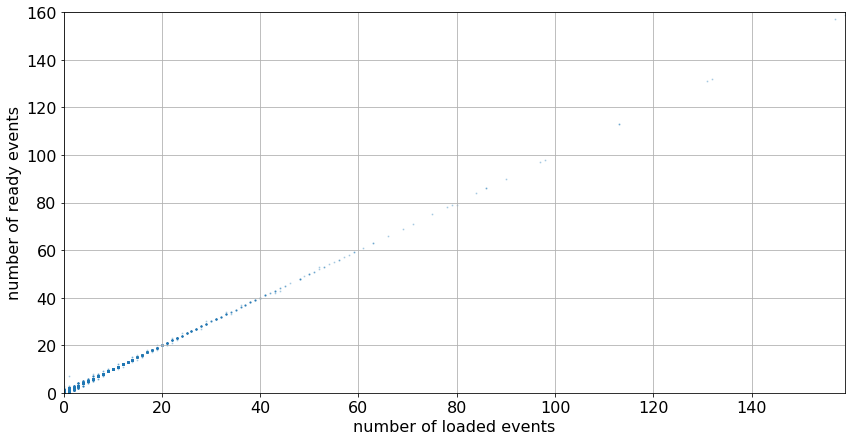

In [31]:
plt.scatter(sessions["loaded_count"], sessions["ready_count"], s=1, alpha=0.25);
plt.xlabel("number of loaded events")
plt.ylabel("number of ready events");

The reason seems to that sessions frequently feature repeated pairs of `loaded` and `ready` cycles. Of the top 20 intra-session patterns of actions, 7 of them include at least two pairs.

In [32]:
pd.DataFrame(sessions["actions"].value_counts()).head(20)

,actions
loaded-ready-abort,236395
loaded-ready,94571
init-loaded-ready-abort,70316
ready-loaded-abort,26431
loaded-ready-loaded-ready,14920
ready-loaded,12920
init-loaded-ready-saveIntent-saveAttempt-saveSuccess,9550
abort,8044
init-loaded-ready,7028
init,5613


# Sessions with inconsistent editors
There are a few sessions that switch editors, starting in the visual editor and ending in the 2017 wikitext editor or the reverse...

In [34]:
sessions.query("~ve_pct.isin([0,1])")["editor"].value_counts()

visualeditor-wikitext-2017    134
wikitext-2017-visualeditor    109
Name: editor, dtype: int64

...however, the number is unimportant.

In [35]:
sessions["editor"].value_counts()

wikitext                      419969
visualeditor                   99842
wikitext-2017                   4088
visualeditor-wikitext-2017       134
wikitext-2017-visualeditor       109
Name: editor, dtype: int64